# ECE NLP

## Overview

In this challenge you will be building a model that automatically determines logical entailment between two sentences.  
The model for this task we chose is a Bidirectionnial LSTM.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.0.0


In [2]:
import numpy as np
import pandas as pd
import csv
import pickle

import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, concatenate, SpatialDropout1D, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

## Data import

#### Import train and test csv files

In [3]:
train_df = pd.read_csv("Data/dataset_train.csv",sep='\t', index_col='index')
test_df = pd.read_csv("Data/dataset_test_no_labels.csv",sep='\t',index_col='index')
labels = train_df['label']

In [4]:
# print(train_df.isna().sum())
# print(test_df.isna().sum())
# print(labels)

In [5]:
# train_df.values[0]

In [6]:
# print(train_df['sentence_1'].values)

## Data Transformation

In [7]:
max_sequence_length = 300
max_vocabulary_size=1000
nb_examples = len(labels)
train_size = int(0.8 * nb_examples)

### Gathering all the words

In [8]:
sentence_1 = train_df['sentence_1'].values
sentence_1_words = [line.split() for line in sentence_1]
assert( len(sentence_1_words) == len(sentence_1))

sentence_2 = train_df['sentence_2'].values
sentence_2_words = [line.split() for line in sentence_2]
assert( len(sentence_2_words) == len(sentence_2))

In [9]:
flat_sentence_1_words = [item for sublist in sentence_1_words for item in sublist]
flat_sentence_2_words = [item for sublist in sentence_2_words for item in sublist]
flat_words = flat_sentence_1_words + flat_sentence_2_words
assert(len(flat_words) == len(flat_sentence_1_words)+len(flat_sentence_2_words))

### Creating and fitting tokenizer

In [10]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(flat_words)

In [11]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Tokenization

In [11]:
sentence_1_tok = tokenizer.texts_to_sequences(train_df["sentence_1"])
sentence_2_tok = tokenizer.texts_to_sequences(train_df["sentence_2"])

In [12]:
#print(len(max(train_df["sentence_1"], key=len)),len(max(sentence_1_tok, key=len)))

In [13]:
print(len(train_df["sentence_1"]))

392662


### Padding

In [14]:
sentence_1_pad = sequence.pad_sequences(sentence_1_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")
sentence_2_pad = sequence.pad_sequences(sentence_2_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")

In [15]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(sentence):
    # Looking up words in dictionary
    words = [reverse_word_map.get(word) for word in sentence]
    return(words)

In [16]:
# Creating texts 
example = 1337

totext1 = list(map(sequence_to_text, [sentence_1_tok[example]]))[0]
totext2 = list(map(sequence_to_text, [sentence_2_tok[example]]))[0]

print("original premise       : ",train_df["sentence_1"][example])
print("tokenized premise      : ",sentence_1_tok[example])
print("de-tokenized premise   : ",totext1)
# print("padded : ",sentence_1_pad[example])

print("original hypothesis    : ",train_df["sentence_2"][example])
print("tokenized hypothesis   : ",sentence_2_tok[example])
print("de-tokenized hypothesis: ",totext2)
# print("padded : ",sentence_2_pad[example])

original premise       :  I wonder whether, after all, you know as much as we think? he said softly.
tokenized premise      :  [7, 389, 115, 35, 11, 31, 21, 100, 21, 29, 67, 22, 79]
de-tokenized premise   :  ['i', 'whether', 'after', 'all', 'you', 'know', 'as', 'much', 'as', 'we', 'think', 'he', 'said']
original hypothesis    :  His voice was gruff and gravelly as he spoke.
tokenized hypothesis   :  [34, 912, 13, 4, 21, 22]
de-tokenized hypothesis:  ['his', 'voice', 'was', 'and', 'as', 'he']


In [17]:
# Check tokenizer
tokenizer.get_config()

{'num_words': 1000,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 11695287,
 'word_counts': '{"conceptually": 20, "cream": 368, "skimming": 79, "has": 35128, "two": 14133, "basic": 1050, "dimensions": 84, "product": 1660, "and": 301193, "geography": 79, "you": 110089, "know": 43009, "during": 6197, "the": 735181, "season": 1207, "i": 154616, "guess": 4957, "at": 50771, "your": 15031, "level": 2570, "uh": 46182, "lose": 975, "them": 23984, "to": 312354, "next": 4418, "if": 30348, "they": 65941, "decide": 728, "recall": 288, "parent": 267, "team": 1914, "braves": 16, "call": 2824, "a": 259005, "guy": 1483, "from": 47490, "triple": 100, "then": 13263, "double": 729, "goes": 2125, "up": 24394, "replace": 373, "him": 14584, "single": 2241, "one": 35281, "of": 309292, "our": 12188, "number": 4859, "will": 28692, "carry": 854, "out": 24856, "instructions": 162, "minutely": 13, "how": 14362, "do":

### Integer encoded Labels

In [18]:
def translate_labels(labels,inverse=False):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    convert_dict_inverse = {
      0: 'entailment',
      1: 'neutral',
      2: 'contradiction'
    }
    new_labels=[]
    if inverse:
        new_labels.append(convert_dict_inverse[labels])
    else:
        for label in labels:
            new_labels.append(convert_dict[label])
    
    return new_labels

In [19]:
num_labels = translate_labels(labels)

## Model Definition

In [20]:
from __future__ import absolute_import, division, print_function, unicode_literals
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [21]:
vocabulary_size = max_vocabulary_size
BATCH_SIZE = 1024
embedding_size = 64
hidden_size = 64
epochs = 10

This next cell is useful to reset the model and to not get any errors during training

In [22]:
premise = tf.keras.Input(shape=(max_sequence_length), name='Premise')        # Sequence of ints
hypothesis = tf.keras.Input(shape=(max_sequence_length), name='Hypothesis')  # Sequence of ints

emb_1 = Embedding(vocabulary_size,embedding_size)(premise)       
emb_2 = Embedding(vocabulary_size,embedding_size)(hypothesis)

x = concatenate([emb_1, emb_2], axis = -2)
x = Bidirectional(tf.keras.layers.LSTM(hidden_size))(x)
x = Dense(hidden_size, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=[premise, hypothesis], outputs=x)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
premise = tf.keras.Input(shape=(max_sequence_length), name='Premise')        # Sequence of ints
hypothesis = tf.keras.Input(shape=(max_sequence_length), name='Hypothesis')  # Sequence of ints

emb_1 = Embedding(vocabulary_size,embedding_size)(premise)  
emb_1 = SpatialDropout1D(0.2)(emb_1)
emb_1 = Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(emb_1)
emb_1 = Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(emb_1)
emb_1 = Dropout(0.25)(emb_1)
emb_1 = GlobalMaxPooling1D()(emb_1)
     
emb_2 = Embedding(vocabulary_size,embedding_size)(hypothesis)
emb_2 = SpatialDropout1D(0.2)(emb_2)
emb_2 = Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(emb_2)
emb_2 = Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(emb_2)
emb_2 = Dropout(0.25)(emb_2)
emb_2 = GlobalMaxPooling1D()(emb_2)

x = concatenate([emb_1, emb_2], axis = -2)
x = Dense(hidden_size, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model2 = Model(inputs=[premise, hypothesis], outputs=x)
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Premise (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
Hypothesis (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 64)      64000       Premise[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 64)      64000       Hypothesis[0][0]                 
____________________________________________________________________________________________

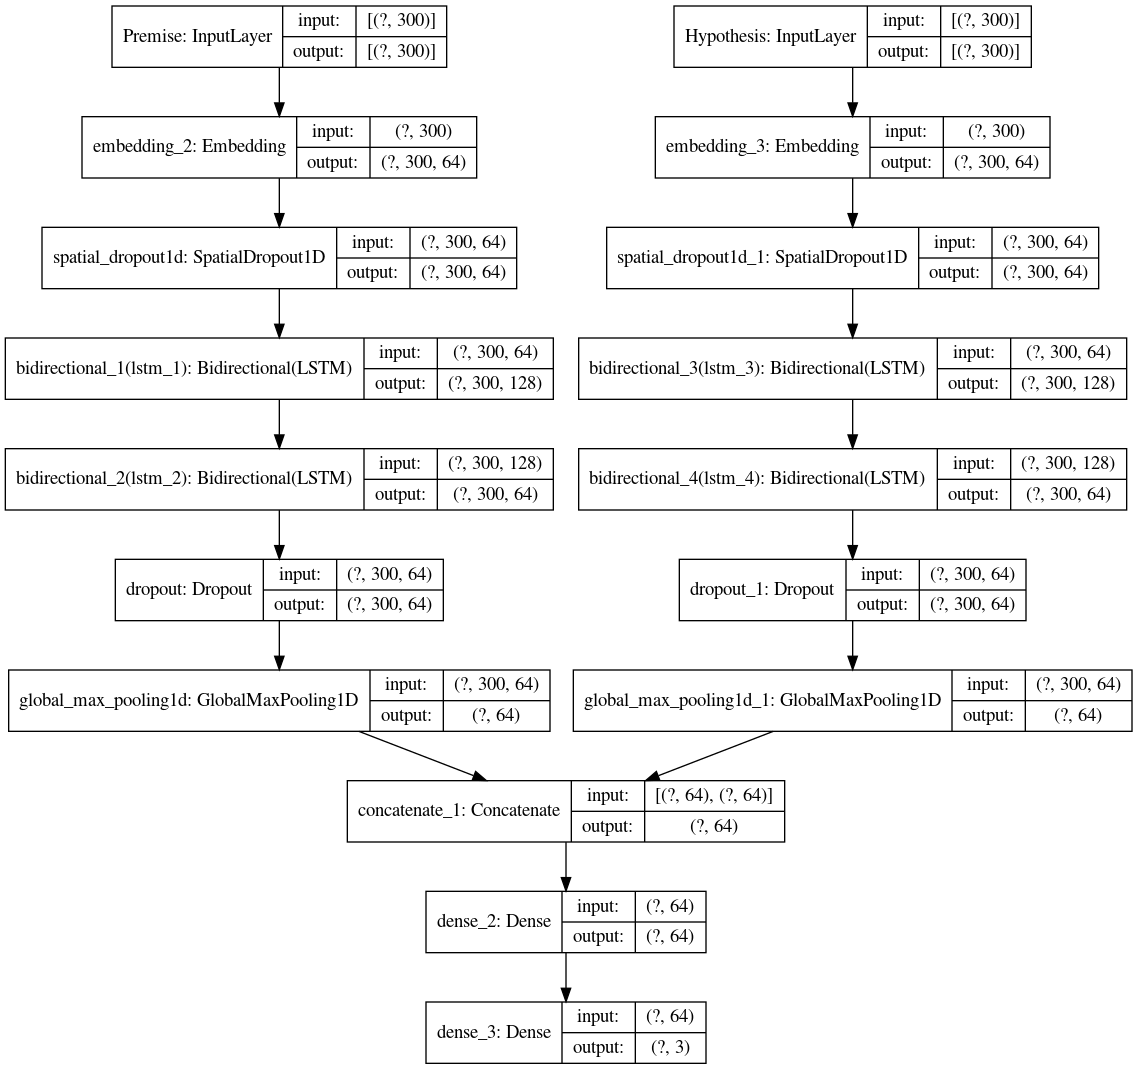

In [25]:
tf.keras.utils.plot_model(model2, 'model2.png', show_shapes=True)

In [26]:
tf.keras.utils.plot_model(new_model, 'model1.png', show_shapes=True)

NameError: name 'new_model' is not defined

## Model Training/Evaluation

### Preparing dataset for training

In [ ]:
def input_fn(input_1,input_2, labels, BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(({"Premise": input_1, "Hypothesis": input_2}, labels))
    #dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
dataset = input_fn(sentence_1_pad,sentence_2_pad, num_labels, BATCH_SIZE)
dataset

### Splitting dataset into training/validation

In [ ]:
train_dataset = dataset.take(train_size) 
val_dataset = dataset.skip(train_size)

### Training the network

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
dataset = input_fn(sentence_1_pad,sentence_2_pad, num_labels, 2048)
dataset

In [ ]:
dataset

In [53]:
model.fit(dataset,
          epochs=10,
          verbose=1)

Epoch 1/10
      1/Unknown - 21s 21s/step

CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node Reshape_8/_48}}]] [Op:__inference_distributed_function_10739]

Function call stack:
distributed_function


In [ ]:
model.fit(dataset,
          epochs=10,
          verbose=1,
          callbacks=[cp_callback])

Epoch 1/10


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f76e952ac20>
Traceback (most recent call last):
  File "/home/artyom/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 541, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/artyom/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1157, in delete_iterator
    "DeleteIterator", handle=handle, deleter=deleter, name=name)
  File "/home/artyom/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/home/artyom/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py", line 544, in create_op
    inp = self.capture(inp)
  File "/home/artyom/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/func_graph.py", line 605, in capture
    return self._capture_helper(tensor, name)
  File 

In [41]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [43]:
model.fit(train_dataset, 
          steps_per_epoch= train_size // BATCH_SIZE,
          validation_data=val_dataset,
          validation_steps= ( nb_examples - train_size ) // BATCH_SIZE,
          epochs=10,
          verbose=1,
          callbacks=[cp_callback])

Train for 306 steps, validate for 76 steps
Epoch 1/10
  1/306 [..............................] - ETA: 1:28
Epoch 00001: saving model to training_1/cp.ckpt


ValueError: Error when checking input: expected Premise to have shape (300,) but got array with shape (1,)

In [36]:
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [3]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


ValueError: You tried to call `count_params` on Premise, but the layer isn't built. You can build it manually via: `Premise.build(batch_input_shape)`.

## Model Inference

In [ ]:
test_sentence_1_tok = tokenizer.texts_to_sequences(test_df["sentence_1"])
test_sentence_2_tok = tokenizer.texts_to_sequences(test_df["sentence_2"])

test_sentence_1_pad = sequence.pad_sequences(test_sentence_1_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")
test_sentence_2_pad = sequence.pad_sequences(test_sentence_2_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")

In [ ]:
tmp = []
tmp.append(test_sentence_1_pad)
tmp.append(test_sentence_2_pad)

X_test = np.array(tmp)

In [ ]:
predict = model.predict([X_test[0],X_test[1]],verbose=True)

In [ ]:
pred_labels=pd.DataFrame(columns=["index","label"])

for index,pred in enumerate(predict):
    real_label = translate_labels(np.round(np.argmax(pred)),inverse=True)
    real_label = str(real_label).strip('[]').replace("'","")
    pred_labels = pred_labels.append({'index':index, 'label':real_label},ignore_index=True)

In [ ]:
pred_labels

## Export results

In [ ]:
pred_labels.to_csv('submission.csv', index = False)

In [ ]:
TableBIS = pd.read_csv("submission.csv", sep="\t")
print(TableBIS)